<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_1_minute_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of a million single-cells in a minute

This notebook runs in about 1 minute and demonstrates the use of the kallisto and bustools programs for pre-processing single-cell RNA-seq data. It downloads and then quantifies 1 million C. elegans single-cells, demonstrating the speed and simplicity of kallisto and bustools. The notebook was perpared for the Genome Informatics 2019 meeting by Sina Booeshaghi, where he presented it as a 1 minute "lightning talk". It is based on methods and data described in the following publications:
* Bray, N. L., Pimentel, H., Melsted, P. & Pachter, L. Near-optimal probabilistic RNA-seq quantification. Nat. Biotechnol. 34, 525–527 (2016).
* Melsted, P., Ntranos, V. & Pachter, L. The Barcode, UMI, Set format and BUStools. Bioinformatics (2019). doi:10.1093/bioinformatics/btz279
* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. BioRxiv (2019). doi:10.1101/673285
* Packer, J., Zhu, Q. et al. A lineage-resolved molecular atlas of C. elegans embryogenesis at single-cell resolution. Science (2019). doi:10.1126/science.aax1971

In [0]:
import time
start_time = time.time()

## Install `kb`

`kb` is a wrapper for the kallisto and bustools program, and the kb-python package contains with the kallisto and bustools executables.

In [118]:
kb_time=time.time()
!pip install kb-python==0.24.1
print(time.time()-kb_time, "seconds")

2.9401535987854004 seconds


## Download index

The quantification of single-cell RNA-seq with kallisto requires an index. Indices are species specific and can be generated or downloaded directly with `kb`. Here we download a pre-made index for C. elegans (the idx.idx file) along with an auxillary file (t2g.txt) that describes the relationship between transcripts and genes.

In [119]:
wget_time=time.time()
!wget -O idx.idx https://caltech.box.com/shared/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx
!wget -O t2g.txt https://caltech.box.com/shared/static/cflxji16171skf3syzm8scoxkcvbl97x.txt
print(time.time()-wget_time, "seconds")

--2020-02-01 08:54:49--  https://caltech.box.com/shared/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx
Resolving caltech.box.com (caltech.box.com)... 107.152.26.197, 107.152.27.197
Connecting to caltech.box.com (caltech.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx [following]
--2020-02-01 08:54:49--  https://caltech.box.com/public/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx [following]
--2020-02-01 08:54:49--  https://caltech.app.box.com/public/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.27.199, 107.152.26.199
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.27.199|:443... connected.
HTTP requ

## Run kb

In [120]:
kb_run_time=time.time()
!kb count -i idx.idx -g t2g.txt --overwrite -t 2 -x 10xv2 https://caltech.box.com/shared/static/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz https://caltech.box.com/shared/static/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz
print(time.time()-kb_run_time, "seconds")

[2020-02-01 08:55:19,834]    INFO Piping https://caltech.box.com/shared/static/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz to tmp/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz
[2020-02-01 08:55:19,835]    INFO Piping https://caltech.box.com/shared/static/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz to tmp/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz
[2020-02-01 08:55:19,836]    INFO Generating BUS file from
[2020-02-01 08:55:19,836]    INFO         tmp/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz
[2020-02-01 08:55:19,836]    INFO         tmp/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz
[2020-02-01 08:55:33,867]    INFO Sorting BUS file ./output.bus to tmp/output.s.bus
[2020-02-01 08:55:36,488]    INFO Whitelist not provided
[2020-02-01 08:55:36,488]    INFO Copying pre-packaged 10XV2 whitelist to .
[2020-02-01 08:55:36,587]    INFO Inspecting BUS file tmp/output.s.bus
[2020-02-01 08:55:37,066]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist ./10xv2_whitelist.txt
[2020-02-01 08:55:51,773]    INFO Sor

## Perform basic analysis with SciPy 

Install packages for analysis and plotting.

In [0]:
analysis_run_time=time.time()

In [0]:
from scipy.io import mmread
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy.sparse import csr_matrix
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.figure_format = 'retina'

Read in the matrix.

In [0]:
mtx = mmread("/content/counts_unfiltered/cells_x_genes.mtx")

Perform SVD.

In [0]:
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(mtx)
X = tsvd.transform(mtx)

Plot the cells in the 2-D PCA projection.

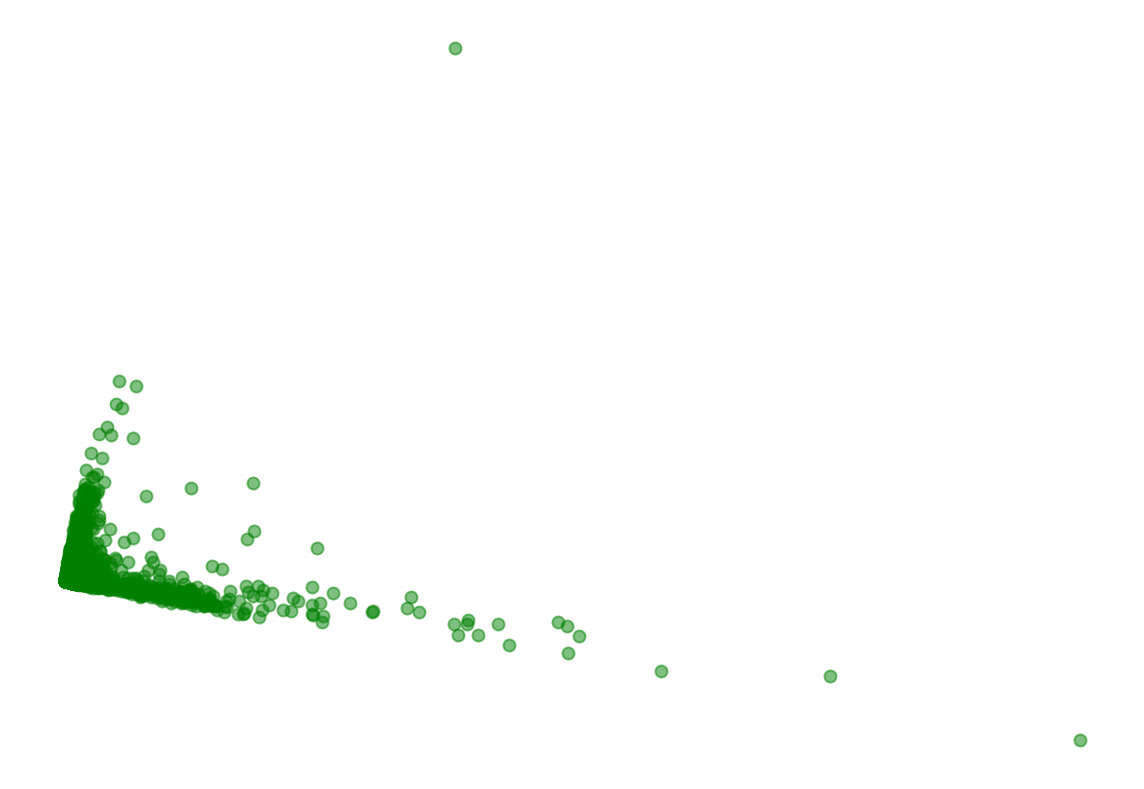

In [125]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.axis('off')
plt.show()

In [0]:
mtx = csr_matrix(mtx)

Create a plot showing genes detected as a function of UMI counts.

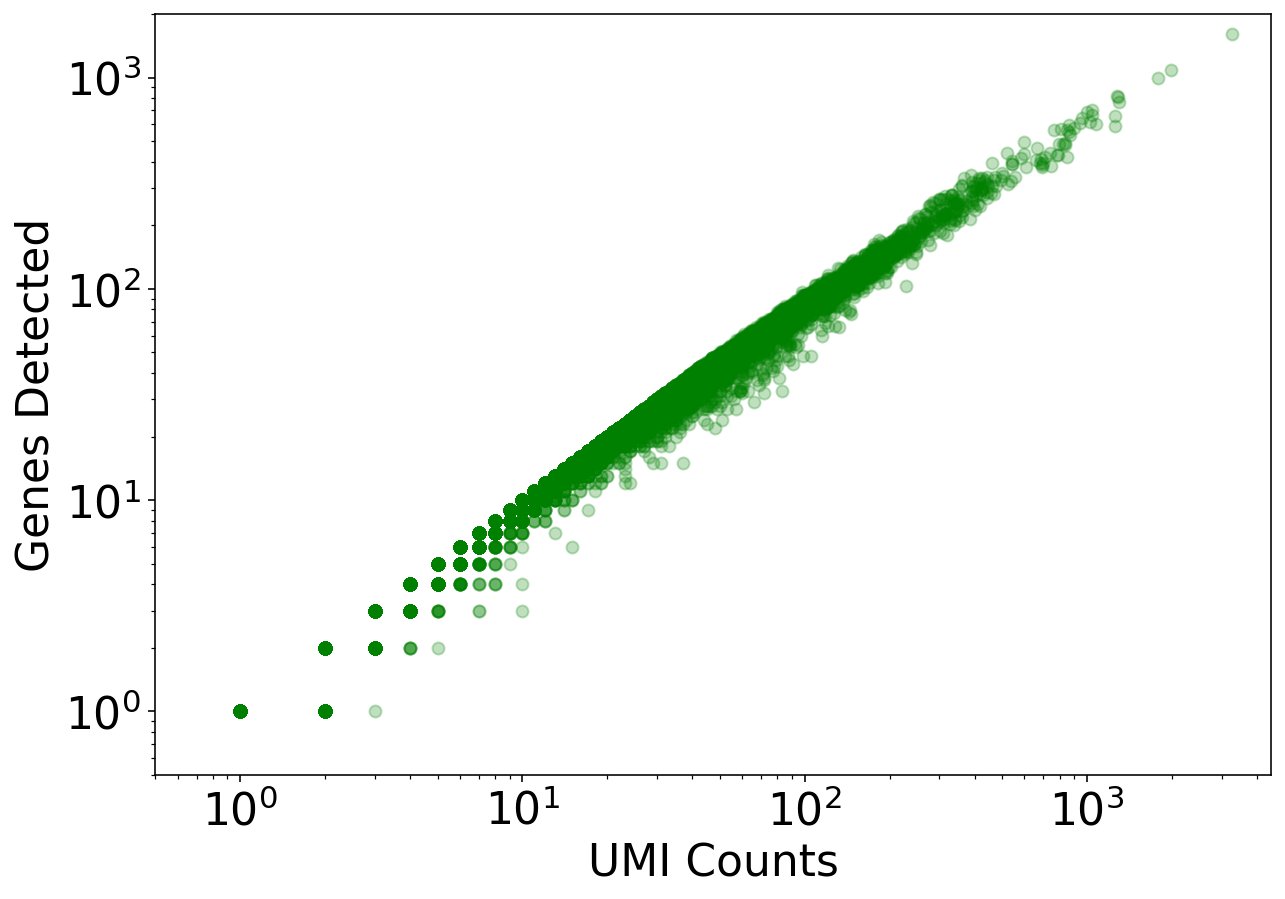

In [127]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1))[:,0], np.asarray(np.sum(mtx>0, axis=1))[:,0], color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()

Create the "knee plot".

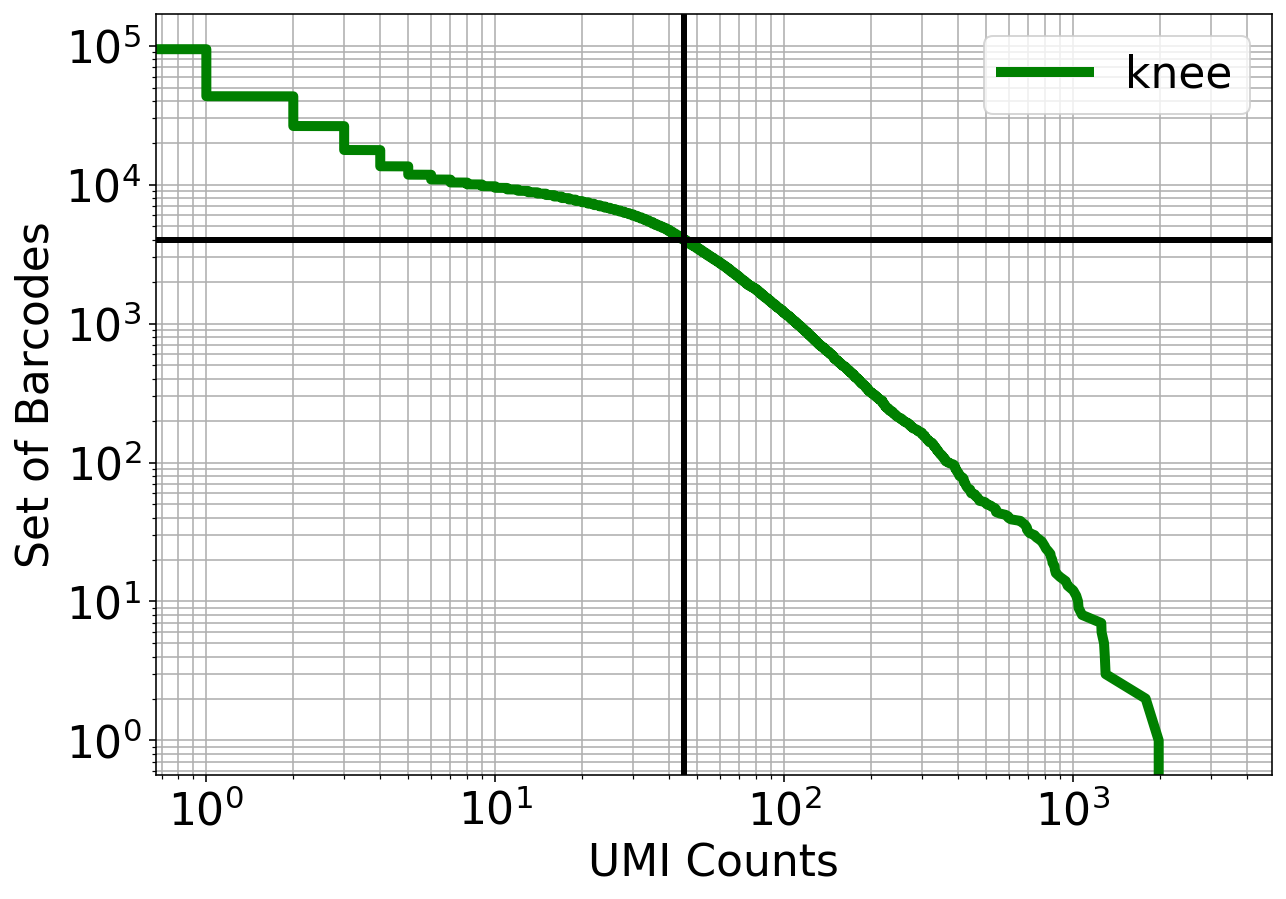

In [128]:
knee = np.sort((np.array(mtx.sum(axis=1))).flatten())[::-1]
fig, ax = plt.subplots(figsize=(10, 7))

expected_num_cells=4000

ax.loglog(knee, range(len(knee)), label='knee',linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
ax.legend()
plt.show()


The analysis took

In [129]:
print(time.time()-analysis_run_time, "seconds")

6.362568140029907 seconds


to run.

The whole notebook took 

In [130]:
print(time.time()-start_time, "seconds")

76.10918760299683 seconds


to run.